In [1]:
# This code was made via and IBM Quantum Lab Notebook with Qiskit.

!pip install qiskit ipywidgets # Installing qiskit for Google Colab
!pip install qiskit-optimization # Needed for an optimzer used (see comment for a specific import)
!pip install cplex # Needed for the CPLEX - it can solve specific types of optimization problems that can be represented as linear or quadratic functions

# This code is related to (not the same) the code made in a separate program, which was an internship I was a part of.
# Importing the mandatory, non-qiskit packages

import numpy as np
import pandas as pd # For the dataset created at the end.
import math
import matplotlib.pyplot as plt
import operator
from time import process_time
from docplex.mp.model import Model
import os.path

import sys
# Just to make sure there are no issues with the python version for the usage of sys.
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

# This is just to make sure there are no issues no matter which platform is being used.
try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")

# Importing packages related to qiskit
from qiskit import QuantumCircuit, Aer, transpile, BasicAer
from qiskit.quantum_info import Pauli
from qiskit.utils import *
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, QAOA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import *
from qiskit_optimization.algorithms import *
from qiskit.opflow import MatrixOp

# For the quantum optimizer
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CplexOptimizer, MinimumEigenOptimizer # Related to the second item installed
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp 



[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Using cached cplex-22.1.1.0-cp310-cp310-manylinux1_x86_64.whl (44.2 MB)

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_61/4163309751.py:35: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import NumPyMinimumEigensolver, VQE, QAOA


# Initializing our Vehicle Routing Problem

In [2]:
# Providing ways for the user to input the number of depots and vehicles they wish to have for this instance of TSP.
# n = input("Enter the number of locations/depots: ")
# v = input("Enter the number of vehicles: ")
n = 4
v = 1

In [3]:
# This is the initialization class.
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_nodes_and_weight_matrix(self, weight_matrix): # This code has been revised to allow for a specific matrix.
        n = self.n
        x = (np.random.rand(n) - 0.5) * 10
        y = (np.random.rand(n) - 0.5) * 10
        weight_matrix = np.array([[0, 45, 20, 5], 
                          [45, 0, 35, 25], 
                          [20, 35, 0, 30], 
                          [5, 25, 30, 0]])
        '''
        weight_matrix = np.zeros([n, n])
        for i in range(n): 
            for j in range(i+1, n):
                weight_matrix[i, j] = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2
                weight_matrix[j, i] = weight_matrix[i, j]
        '''
        return x, y, weight_matrix



In [4]:
#Initializing the problem. The nodes (depots) and a weight matrix are being set-up.
# The weight matrix provides biases towards which edges or roads between depots are more important.
initializer = Initializer(n)
weight_matrix = np.zeros([n, n]) # Enter the weight matrix here.
#for i in range(n): 
    #for j in range(0, n):
        # weight_matrix[i, j] = int(input("Enter what you would like to go into element " + str(i) + "," + str(j) + " of the matrix: "))
x,y,weight_matrix = initializer.generate_nodes_and_weight_matrix(weight_matrix)
print("This is the original weight matrix.")
x,y,old_weight_matrix = initializer.generate_nodes_and_weight_matrix(weight_matrix) # Used for the correct cost.
print(weight_matrix)
def weight_to_binary(weight_matrix): # This is a function that converts the code to a binary matrix.
    n = len(weight_matrix)
    binary_matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if weight_matrix[i][j] != 0:
                binary_matrix[i][j] = 1
    return binary_matrix

# weight_matrix = weight_to_binary(np.array(weight_matrix)) # This is where the weight matrix is converted into an analogous binary matrix, which fixes the issues with my code.
# I have not implemented the code here, but change the weight_matrix to one using the weight_to_binary function.
weight_matrix = weight_to_binary(weight_matrix)
print("This is the binary version of the above weight matrix.")
print(weight_matrix)
# Revise, as this works, but does not considering the weights. The solution and cost are not correct.

This is the original weight matrix.
[[ 0 45 20  5]
 [45  0 35 25]
 [20 35  0 30]
 [ 5 25 30  0]]
This is the binary version of the above weight matrix.
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]


# Quantum Optimization with Warm Starting QAOA

In [5]:
class QuantumOptimizerWarmStart: # For all parts but the cost
    # This version still uses K instead of v, but works, unlike the below WarmStartQuantumOptimizer class. That one is kept due to its comments.
    def __init__(self, weight_matrix, n, K):

        self.weight_matrix = weight_matrix
        self.n = n
        self.K = K

   
    def binary_representation_warm_start(self, x_sol=0): # This is the original version.

        weight_matrix = self.weight_matrix
        n = self.n
        K = self.K

        A = np.max(weight_matrix) * 100  # A parameter of cost function

        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for i in range(n):
            count = i - 1
            for j in range(n * (n - 1)):

                if j // (n - 1) == i:
                    count = i

                if j // (n - 1) != i and j % (n - 1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T) - \
            2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost
    
    

    def construct_problem_warm_start(self, Q, g, c) -> QuadraticProgram:
        mdl = Model()
        x = [mdl.binary_var('x%s' % i) for i in range(n * (n - 1))]

        objective = mdl.sum([g[i] * x[i] for i in range(n * (n - 1))])
        objective += mdl.sum(
            [Q[i, j] * x[i] * x[j] for i in range(n * (n - 1)) for j in range(n * (n - 1))])
        objective += mdl.sum(c)
        mdl.minimize(objective)
        cost = mdl.sum(x)
        qp = from_docplex_mp(mdl)
        return qp
    
    def mini_qaoa(weight_matrix_t2): # Original
        # Define the input matrix
        matrix = weight_matrix_t2
        # Construct a `MatrixOp` object from the input matrix
        matrix_op = MatrixOp(matrix=matrix)

        # Define the number of layers
        p = 5 # changed from one

        # Create a quantum circuit for the QAOA algorithm
        qc = QuantumCircuit(len(matrix))
        for i in range(p):
            # Apply the cost Hamiltonian
            qc += matrix_op.evolve(
                evo_time=-1, num_time_slices=1, quantum_registers=qc.qregs
            )
            # Apply the mixer Hamiltonian
            qc.h(qc.qregs[0])

        # Create a QAOA object from the circuit
        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        return qaoa
    
    

    def solve_problem_warm_start(self, qp): # This is the original version.
        algorithm_globals.random_seed = 43
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        
        ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa,
                                         epsilon=0.0) # Orginal chosen optimizer
        
        # Import the necessary libraries - for the alternative optimizers
        import scipy.optimize


        result = ws_qaoa.solve(qp)
        
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation_warm_start(x_sol=result.x)
        return result, result.x, level
    
    # Functions for getting relevant data
    def get_number_of_layers(self):
        return 5  # The number of layers used in the QAOA circuit

    def get_convergence_criteria(self):
        return 0.1  # Example threshold for the objective function value

    def get_resource_requirements(self):
        # Calculate the circuit depth
        circuit_depth = self.get_number_of_layers() * 2

        # Number of classical iterations
        num_iterations = 100  # Example value

        return circuit_depth, num_iterations

    def compute_energy_gap(self):
        # Construct the QuadraticProgram
        Q, g, _, _ = self.binary_representation_warm_start()
        qp = self.construct_problem_warm_start(Q, g, c=0)

        # Solve the QuadraticProgram using QAOA
        result = self.solve_problem_warm_start(qp)

        # Extract eigenvalues from the result
        eigenvalues = result.eigenvalues
        eigenvalues.sort()  # Sort eigenvalues in ascending order
        energy_gap = eigenvalues[1] - eigenvalues[0]  # Energy gap is the difference between the two lowest eigenvalues

        return energy_gap

    def compute_success_rate(self, num_samples=100):
        success_count = 0

        for _ in range(num_samples):
            # Create an instance of QuantumOptimizerWarmStart for each sample
            quantum_optimizer = QuantumOptimizerWarmStart(self.weight_matrix, self.n, self.K)

            # Solve the problem
            result = quantum_optimizer.solve_problem_warm_start()

            if result.status.is_success():
                success_count += 1

        success_rate = success_count / num_samples

        return success_rate

    def compute_fidelity(self):
        # Construct the QuadraticProgram
        Q, g, _, _ = self.binary_representation_warm_start()
        qp = self.construct_problem_warm_start(Q, g, c=0)

        # Obtain the true ground state using a classical solver (e.g., NumPyMinimumEigensolver)
        classical_optimizer = MinimumEigenOptimizer(NumPyMinimumEigensolver())
        classical_result = classical_optimizer.solve(qp)
        true_ground_state = classical_result.x

        # Create a QAOA instance with the same parameters as your QAOA
        qaoa = self.mini_qaoa()

        # Compute the minimum eigenvalue and eigenstate using QAOA
        qaoa_result = qaoa.compute_minimum_eigenvalue(qp)
        obtained_ground_state = qaoa_result.eigenstate

        # Calculate fidelity
        fidelity = self.calculate_fidelity(true_ground_state, obtained_ground_state)

        return fidelity

    def calculate_fidelity(self, true_state, obtained_state):
        # Compute the fidelity between true and obtained quantum states
        overlap = np.abs(np.dot(true_state.conj(), obtained_state))
        fidelity = overlap * overlap
        return fidelity


In [6]:
class QuantumOptimizerWarmStartRevisedCost: # For the cost only
    # This version still uses K instead of v, but works, unlike the below WarmStartQuantumOptimizer class. That one is kept due to its comments.
    def __init__(self, old_weight_matrix, n, K):

        self.weight_matrix = old_weight_matrix # This the main difference, using another version of the input matrix. 
        self.n = n
        self.K = K

   
    def binary_representation_warm_start(self, x_sol=0): # This is the original version,

        weight_matrix = self.weight_matrix
        n = self.n
        K = self.K

        A = np.max(weight_matrix) * 100  # A parameter of cost function

        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for i in range(n):
            count = i - 1
            for j in range(n * (n - 1)):

                if j // (n - 1) == i:
                    count = i

                if j // (n - 1) != i and j % (n - 1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T) - \
            2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost
    
    

    def construct_problem_warm_start(self, Q, g, c) -> QuadraticProgram:
        mdl = Model()
        x = [mdl.binary_var('x%s' % i) for i in range(n * (n - 1))]

        objective = mdl.sum([g[i] * x[i] for i in range(n * (n - 1))])
        objective += mdl.sum(
            [Q[i, j] * x[i] * x[j] for i in range(n * (n - 1)) for j in range(n * (n - 1))])
        objective += mdl.sum(c)
        mdl.minimize(objective)
        cost = mdl.sum(x)
        qp = from_docplex_mp(mdl)
        return qp
    
    def mini_qaoa(weight_matrix_t2): # Original
        # Define the input matrix
        matrix = weight_matrix_t2
        # Construct a `MatrixOp` object from the input matrix
        matrix_op = MatrixOp(matrix=matrix)

        # Define the number of layers
        p = 5 # changed from one

        # Create a quantum circuit for the QAOA algorithm
        qc = QuantumCircuit(len(matrix))
        for i in range(p):
            # Apply the cost Hamiltonian
            qc += matrix_op.evolve(
                evo_time=-1, num_time_slices=1, quantum_registers=qc.qregs
            )
            # Apply the mixer Hamiltonian
            qc.h(qc.qregs[0])

        # Create a QAOA object from the circuit
        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        return qaoa
    
    


    def solve_problem_warm_start(self, qp): # This is the original version.
        algorithm_globals.random_seed = 43
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa,
                                         epsilon=0.0)
        result = ws_qaoa.solve(qp)
        
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation_warm_start(x_sol=result.x)
        return result, result.x, level
    

In [7]:
# Uses a similar class to the  quantum optimizer class in my previous iteration of QAOA.
# This is the quantum optimizer class being used for QAOA

# This version does not seem to work, but this version has comments explaining the code, hence it still being here.
"""
class QuantumOptimizerWarmStart_V2:

    def __init__(self, weight_matrix, n, K):
        self.weight_matrix = weight_matrix
        self.n = n
        self.v = v
    
    
    def binary_representation_warm_start(self, x_sol=0): # This is the original version.
        weight_matrix = self.weight_matrix
        n = self.n
        v = self.v
        A = np.max(weight_matrix) * 100  # A parameter of cost function
        
        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]
            
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for i in range(n):
            count = i - 1
            for j in range(n * (n - 1)):

                if j // (n - 1) == i:
                    count = i

                if j // (n - 1) != i and j % (n - 1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T) - \
            2 * A * v * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (v ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost
    
    # This sets up all the variables from the previous function for the final quantum algorithm being run.
    def construct_problem_warm_start(self, Q, g, c) -> QuadraticProgram:
        mdl = Model()
        x = [mdl.binary_var('x%s' % i) for i in range(n * (n - 1))]

        objective = mdl.sum([g[i] * x[i] for i in range(n * (n - 1))])
        objective += mdl.sum(
            [Q[i, j] * x[i] * x[j] for i in range(n * (n - 1)) for j in range(n * (n - 1))])
        objective += mdl.sum(c)
        mdl.minimize(objective)
        cost = mdl.sum(x)
        qp = from_docplex_mp(mdl)
        return qp

    def solve_problem_warm_start(self, qp): # This function solves the function and allows one the get the optimal solution.
        algorithm_globals.random_seed = 1000 # Random number
        # This "quantum instance" code is used to run any qiskit-aqua based algorithm.
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)
        # qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.]) 
        qaoa = mini_qaoa(weight_matrix_t2)
        # Implementing Warm-Start QAOA
        from qiskit.algorithms.optimizers import COBYLA # Trying a different optimizer, but I still get the same results. Was used the CplexOptimizer() previously.
        ws_qaoa = WarmStartQAOAOptimizer(pre_solver=COBYLA(), relax_for_pre_solver=True, qaoa=qaoa, epsilon=0.0)
        # Used to approxiate the ground state/lowest eneergy of the resulting hamiltonian
        result = ws_qaoa.solve(qp)
        # Used for computing cost of the obtained result (these two lines of code are from the internship code
        _, _, _, level = self.binary_representation_warm_start(x_sol=result.x)
        return result, result.x, level
 """

'\nclass QuantumOptimizerWarmStart_V2:\n\n    def __init__(self, weight_matrix, n, K):\n        self.weight_matrix = weight_matrix\n        self.n = n\n        self.v = v\n    \n    \n    def binary_representation_warm_start(self, x_sol=0): # This is the original version.\n        weight_matrix = self.weight_matrix\n        n = self.n\n        v = self.v\n        A = np.max(weight_matrix) * 100  # A parameter of cost function\n        \n        # Determine the weights w\n        weight_matrix_vec = weight_matrix.reshape(n ** 2)\n        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]\n        w = np.zeros(n * (n - 1))\n        for i in range(len(w_list)):\n            w[i] = w_list[i]\n            \n        Id_n = np.eye(n)\n        Im_n_1 = np.ones([n - 1, n - 1])\n        Iv_n_1 = np.ones(n)\n        Iv_n_1[0] = 0\n        Iv_n = np.ones(n - 1)\n        neg_Iv_n_1 = np.ones(n) - Iv_n_1\n\n        v = np.zeros([n, n * (n - 1)])\n        for i in rang

In [8]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer_warm_start = QuantumOptimizerWarmStart(weight_matrix, n, v)
quantum_optimizer_warm_start_cost_only = QuantumOptimizerWarmStartRevisedCost(old_weight_matrix, n, v)

In [9]:
Q_warm_start, g_warm_start, c_warm_start, binary_cost_warm_start_2 = quantum_optimizer_warm_start.binary_representation_warm_start()
Q_warm_start_2, g_warm_start_2, c_warm_start_2, binary_cost_warm_start = quantum_optimizer_warm_start_cost_only.binary_representation_warm_start()

In [10]:
qp_warm_start = quantum_optimizer_warm_start.construct_problem_warm_start(Q_warm_start, g_warm_start, c_warm_start)
qp_warm_start_2 = quantum_optimizer_warm_start_cost_only.construct_problem_warm_start(Q_warm_start_2, g_warm_start_2, c_warm_start_2)
print(qp_warm_start)

minimize 200*x0^2 + 200*x0*x1 + 200*x0*x10 + 200*x0*x2 + 200*x0*x7 + 200*x1^2 + 200*x1*x11 + 200*x1*x2 + 200*x1*x4 + 200*x10^2 + 200*x10*x11 + 200*x11^2 + 200*x2^2 + 200*x2*x5 + 200*x2*x8 + 200*x3^2 + 200*x3*x4 + 200*x3*x5 + 200*x3*x6 + 200*x3*x9 + 200*x4*x11 + 200*x4^2 + 200*x4*x5 + 200*x5^2 + 200*x5*x8 + 200*x6^2 + 200*x6*x7 + 200*x6*x8 + 200*x6*x9 + 200*x7*x10 + 200*x7^2 + 200*x7*x8 + 200*x8^2 + 200*x9*x10 + 200*x9*x11 + 200*x9^2 - 399*x0 - 399*x1 - 399*x10 - 399*x11 - 399*x2 - 399*x3 - 399*x4 - 399*x5 - 399*x6 - 399*x7 - 399*x8 - 399*x9 + 800 (12 variables, 0 constraints, 'docplex_model1')


In [11]:
# Using what has been created so far, we will now use the warm-start QAOA to solve TSP
t_start = process_time() # When process starts
quantum_warm_start, quantum_solution_warm_start, quantum_cost_warm_start_2= quantum_optimizer_warm_start.solve_problem_warm_start(qp_warm_start)
quantum_warm_start_2, quantum_solution_warm_start_2, quantum_cost_warm_start = quantum_optimizer_warm_start_cost_only.solve_problem_warm_start(qp_warm_start_2)
t_stop = process_time() # When process ends
t = t_stop-t_start # Total runtime
   
print("Elapsed time during the whole program in seconds:", t)# Printing the time the program took to run.
print("Quantum Solution: ", quantum_solution_warm_start) # Printing the quantum solution.
print("Quantum Cost: ", quantum_cost_warm_start) # Printing the quantum cost.

/tmp/ipykernel_61/2696640285.py:108: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
/tmp/ipykernel_61/2696640285.py:112: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
/tmp/ipykernel_61/2065975324.py:109: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 mo

Elapsed time during the whole program in seconds: 7.998204514999999
Quantum Solution:  [1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
Quantum Cost:  80.0


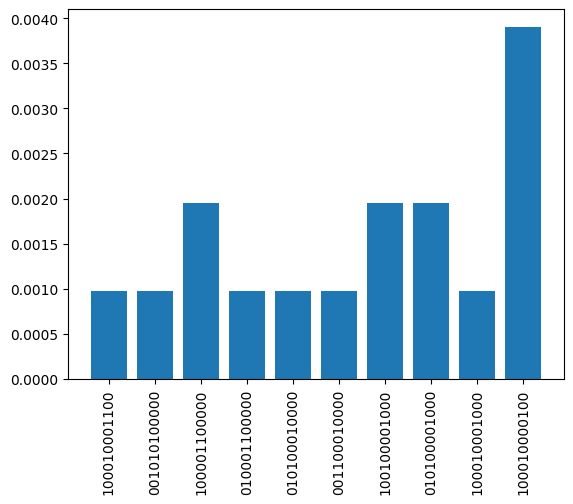

In [12]:
def samples_to_graph(data):
    data_val={}
    data_prob={}
    for i in data:
        arr=i.x.tolist()
        arr=[str(int(i)) for i in arr]
        key=''.join(arr)
        data_val[key]=i.fval
        data_prob[key]=i.probability
    data_val_sorted=sorted(data_val, key=data_val.get)
    least_10=data_val_sorted[0:10]
    plot_dic={}
    for i in least_10:
        plot_dic[i]=data_prob[i]
    plt.xticks(rotation=90)
    plt.bar(range(len(plot_dic)), plot_dic.values(), tick_label=least_10)
    
    return least_10[0], plot_dic

    
optimal_10_warm_start, optimal_10_prob_warm_start = samples_to_graph(quantum_warm_start.samples) 
# The most optimal solutions will be plotted in descending order with most optimal solution being the first.


In [13]:
def visualize_solution(xc, yc, x, C, n, v, title_str): # This a revised version that removes the arrows (for easier readability) and is more efficient for larger inputs.
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)
    plt.grid()

    xs, ys = [], []
    for ii in range(0, n ** 2):
        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            xs.append(xc[ix])
            xs.append(xc[iy])
            xs.append(None)
            ys.append(yc[ix])
            ys.append(yc[iy])
            ys.append(None)

    plt.plot(xs, ys, 'k-', linewidth=1, alpha=0.7)

    plt.title(title_str + ' Cost = ' + str(int(C * 100) / 100.))
    plt.show()

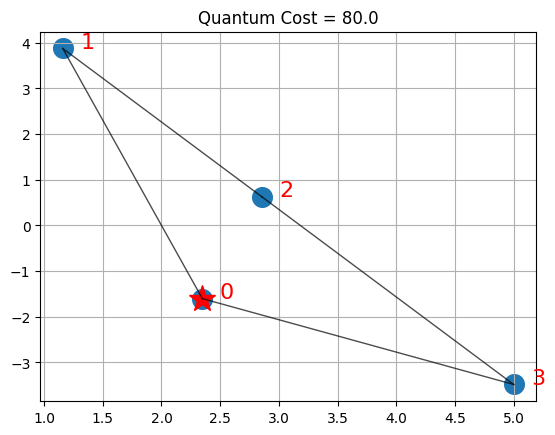

In [14]:
 # Put the solution in a way that is compatible with the classical variables
 # This function was used from the internship, after some explanation from the mentor.
 # Same as previously made code for QAOA.x_quantum = np.zeros(n**2)

        
x_quantum = np.zeros(n**2)
vv = 0
for ii in range(n ** 2):
    if ii // n != ii % n: # if the larger float less than or equal to the division of a/n does not equal the remainder of a divided by n...
        x_quantum[ii] = quantum_solution_warm_start[vv] # quantum_solution was created from the solve_problem method of the quantum_optimizer class
        vv +=  1


# visualize the solution
visualize_solution(x, y, x_quantum, quantum_cost_warm_start, n, v, 'Quantum')

In [15]:
# Storing the solutions within a dataframe and eventually outputting them in an easy-to-understand manner
def solutions_to_df(n, v, optimal_10, quantum_cost, optimal_10_prob):
    dfdata = np.array([n, v, optimal_10, quantum_cost, optimal_10_prob[optimal_10], t])
    df = pd.DataFrame(data=dfdata, index=['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']).transpose()
    return df

In [16]:
### Combining all the Warm Starting QAOA results into a single Dataframe and saving it as a file ###
filename = 'results_warm_start_QAOA.csv'
if os.path.isfile(filename): 
    result_df_warm_start = pd.read_csv(filename)
    df_warm_start = solutions_to_df(n, v, optimal_10_warm_start, quantum_cost_warm_start, optimal_10_prob_warm_start) 
    result_df_warm_start = result_df_warm_start.append(df_warm_start)
else:
    df_warm_start = solutions_to_df(n, v, optimal_10_warm_start, quantum_cost_warm_start, optimal_10_prob_warm_start)
    result_df_warm_start = pd.DataFrame(df_warm_start)
result_df_warm_start.to_csv(filename)
result_df_warm_start[['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']]

/tmp/ipykernel_61/677852498.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_warm_start = result_df_warm_start.append(df_warm_start)


,n (No. of locations),K (No. of vehicles),Quantum Solution,Quantum Cost,Probability,Execution Time (in s)
0,3,1,100110,127.829438,0.018555,1.941189
1,3,1,100110,153.420375,0.018555,1.111159
2,3,1,100110,200.689139,0.018555,1.824768
3,3,1,100110,69.188017,0.016602,0.726974
4,3,1,100110,211.416949,0.017578,1.15594
...,...,...,...,...,...,...
88,4,1,100010001100,80.0,0.000977,6.564788
89,4,1,100010001100,80.0,0.000977,8.075396
90,4,1,100010001100,80.0,0.000977,7.674351
91,4,1,100010001100,80.0,0.000977,7.385401


# Quantum Optimization with Standard QAOA

In [17]:
#Defining our Quantum Optimizer class
# Note, the solution and the cost for Standard QAOA are incorrect. This needs to be fixed.

class QuantumOptimizer:

    def __init__(self, weight_matrix, n, K):

        self.weight_matrix = weight_matrix
        self.n = n
        self.K = K

    def binary_representation(self,x_sol=0):

        weight_matrix = self.weight_matrix
        n = self.n
        K = self.K

        A = np.max(weight_matrix) * 100  # A parameter of cost function

        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for i in range(n):
            count = i-1
            for j in range(n*(n-1)):

                if j//(n-1) == i:
                    count = i

                if j//(n-1) != i and j%(n-1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var()
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 43
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        return result, result.x, level

In [18]:
# Instantiate the quantum optimizer class with parameters:
print(weight_matrix)
quantum_optimizer = QuantumOptimizer(weight_matrix, n, v)

[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]


In [19]:
Q, g, c, binary_cost = quantum_optimizer.binary_representation() # Getting important variables, especially the binary cost

In [20]:
qp = quantum_optimizer.construct_problem(Q, g, c)
print(qp)
# Printing the equations, variables, and constraints used

minimize 200*x0^2 + 200*x0*x1 + 200*x0*x10 + 200*x0*x2 + 200*x0*x7 + 200*x1^2 + 200*x1*x11 + 200*x1*x2 + 200*x1*x4 + 200*x10^2 + 200*x10*x11 + 200*x11^2 + 200*x2^2 + 200*x2*x5 + 200*x2*x8 + 200*x3^2 + 200*x3*x4 + 200*x3*x5 + 200*x3*x6 + 200*x3*x9 + 200*x4*x11 + 200*x4^2 + 200*x4*x5 + 200*x5^2 + 200*x5*x8 + 200*x6^2 + 200*x6*x7 + 200*x6*x8 + 200*x6*x9 + 200*x7*x10 + 200*x7^2 + 200*x7*x8 + 200*x8^2 + 200*x9*x10 + 200*x9*x11 + 200*x9^2 - 399*x0 - 399*x1 - 399*x10 - 399*x11 - 399*x2 - 399*x3 - 399*x4 - 399*x5 - 399*x6 - 399*x7 - 399*x8 - 399*x9 + 800 (12 variables, 0 constraints, '')


In [21]:
### Solving Vehicle Routing Problem with Standard QAOA ###
t_start = process_time()
quantum, quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)
t_stop = process_time()
t = t_stop-t_start
   
print("Elapsed time during the whole program in seconds:", t)

print(quantum_solution, quantum_cost)

/tmp/ipykernel_61/2671839105.py:79: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
/tmp/ipykernel_61/2671839105.py:83: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])


Elapsed time during the whole program in seconds: 7.414847954000001
[0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.] 4.0


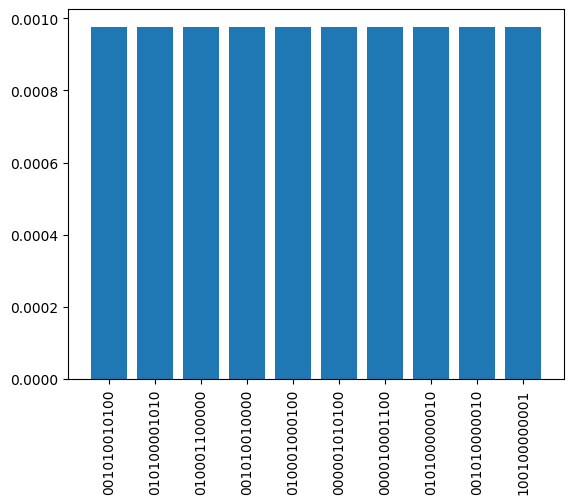

In [22]:
### Plotting Samples to Bar Graph ###
    
optimal_10, optimal_10_prob = samples_to_graph(quantum.samples) 
# The most optimal solutions will be plotted in descending order with most optimal solution being the first

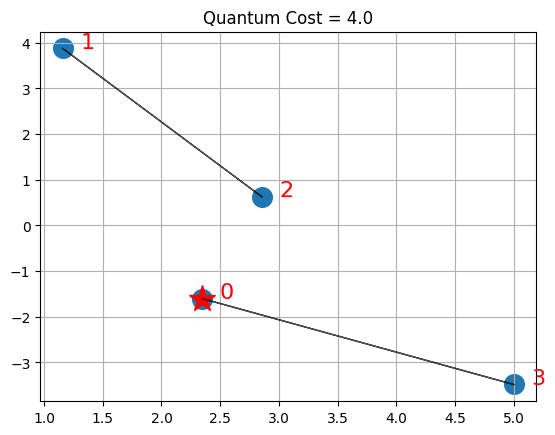

In [23]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
vv = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[vv]
        vv +=  1

# visualize the solution
visualize_solution(x, y, x_quantum, quantum_cost, n, v, 'Quantum')

In [24]:
### Combining all the Standard QAOA results into a single Dataframe and saving it as a file ###
filename = 'results_standard_QAOA.csv'
if os.path.isfile(filename):
    result_df_standard = pd.read_csv(filename)
    df_standard = solutions_to_df(n, v, optimal_10, quantum_cost, optimal_10_prob)
    result_df_standard = result_df_standard.append(df_standard)
else:
    df_standard = solutions_to_df(n, v, optimal_10, quantum_cost, optimal_10_prob)
    result_df_standard = pd.DataFrame(df_standard)
result_df_standard.to_csv(filename)
# Look into the six-digit solution.
result_df_standard[['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']]

/tmp/ipykernel_61/3419324770.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df_standard = result_df_standard.append(df_standard)


,n (No. of locations),K (No. of vehicles),Quantum Solution,Quantum Cost,Probability,Execution Time (in s)
0,3,1,100110,127.829438,0.018555,1.243264
1,3,1,100110,153.420375,0.018555,1.032496
2,3,1,100110,200.689139,0.018555,1.257745
3,3,1,100110,69.188017,0.018555,0.859824
4,3,1,100110,69.188017,0.018555,0.859824
...,...,...,...,...,...,...
89,4,1,1010010100,4.0,0.000977,6.529531
90,4,1,1010010100,4.0,0.000977,7.512149
91,4,1,1010010100,4.0,0.000977,7.522492
92,4,1,1010010100,4.0,0.000977,5.859218


# Comparing Standard QAOA and Warm Starting QAOA

### Comparing Quantum Cost computed using Standard QAOA vs Warm Starting QAOA

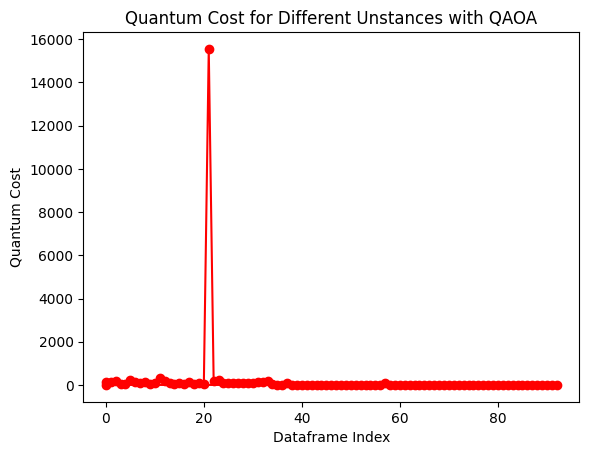

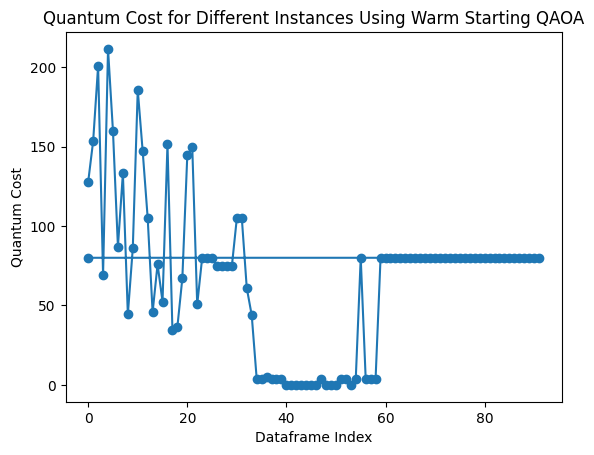

In [25]:
index = result_df_standard.index
standard_np_q_cost = result_df_standard['Quantum Cost'].to_numpy()
plt.plot(index, standard_np_q_cost, marker='o', color='red')
plt.title('Quantum Cost for Different Unstances with QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Quantum Cost')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_cost = result_df_warm_start['Quantum Cost'].to_numpy()
plt.plot(index_warm, warm_start_np_q_cost, marker='o')
plt.title('Quantum Cost for Different Instances Using Warm Starting QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Quantum Cost')
plt.show()

### Comparing Probability computed using Standard QAOA vs Warm Starting QAOA

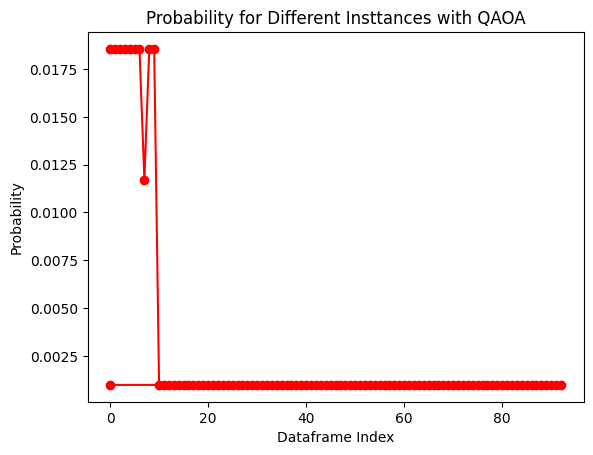

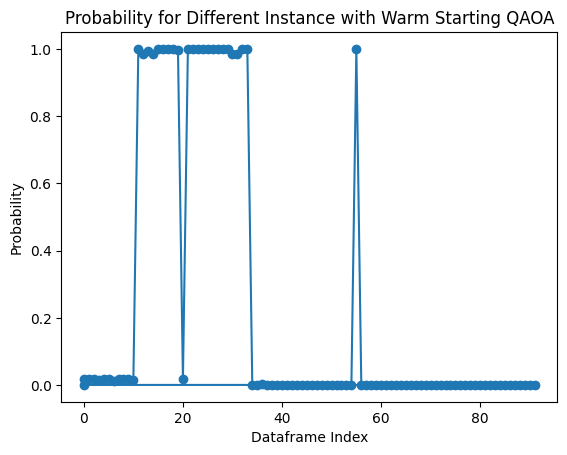

In [26]:
index = result_df_standard.index
standard_np_q_prob = result_df_standard['Probability'].to_numpy()
plt.plot(index, standard_np_q_prob, marker='o', color='red')
plt.title('Probability for Different Insttances with QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Probability')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_prob = result_df_warm_start['Probability'].to_numpy()
plt.plot(index_warm, warm_start_np_q_prob, marker='o')
plt.title('Probability for Different Instance with Warm Starting QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Probability')
plt.show()

### Comparing Execution Time (in s) computed using Standard QAOA vs Warm Starting QAOA

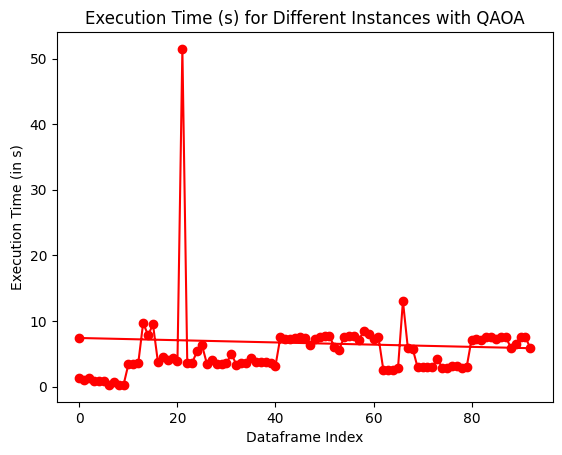

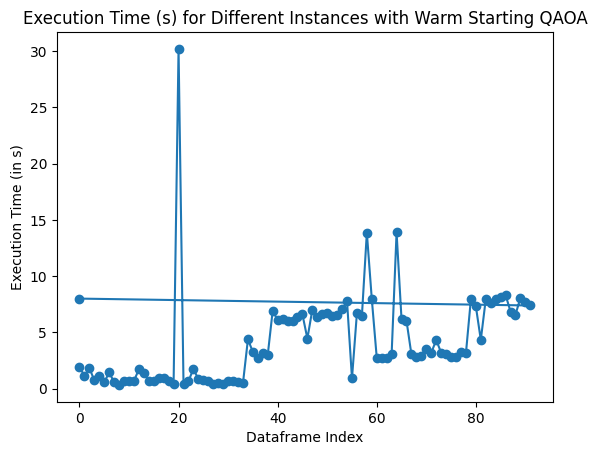

In [27]:
index = result_df_standard.index
standard_np_q_time = result_df_standard['Execution Time (in s)'].to_numpy()
plt.plot(index, standard_np_q_time, marker='o', color='red')
plt.title('Execution Time (s) for Different Instances with QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Execution Time (in s)')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_time = result_df_warm_start['Execution Time (in s)'].to_numpy()
plt.plot(index_warm, warm_start_np_q_time, marker='o')
plt.title('Execution Time (s) for Different Instances with Warm Starting QAOA')
plt.xlabel('Dataframe Index')
plt.ylabel('Execution Time (in s)')
plt.show()

In [28]:
# Data collection items
# Note that the current data collection functions are not working, including this block.
quantum_optimizer = QuantumOptimizerWarmStart(weight_matrix, n, v)

#energy_gap = quantum_optimizer.compute_energy_gap()
#print("Energy Gap:", energy_gap)

#success_rate = quantum_optimizer.compute_success_rate()
#print("Success Rate:", success_rate)

fidelity = quantum_optimizer.compute_fidelity()
print("Fidelity:", fidelity)  # Implement fidelity calculation if needed

num_layers = quantum_optimizer.get_number_of_layers()
print("Number of Layers:", num_layers)

convergence_criteria = quantum_optimizer.get_convergence_criteria()
print("Convergence Criteria:", convergence_criteria)

circuit_depth, num_iterations = quantum_optimizer.get_resource_requirements()
print("Resource Requirements:")
print("- Circuit Depth:", circuit_depth)
print("- Number of Classical Iterations:", num_iterations)
# Not working - all code in this block.

Traceback (most recent call last):
  Cell In[28], line 10
    fidelity = quantum_optimizer.compute_fidelity()
  Cell In[5], line 186 in compute_fidelity
    qaoa = self.mini_qaoa()
  Cell In[5], line 85 in mini_qaoa
    matrix_op = MatrixOp(matrix=matrix)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:95 in wrapper
    return func(*args, **kwargs)
TypeError: MatrixOp.__init__() got an unexpected keyword argument 'matrix'

Use %tb to get the full traceback.


/tmp/ipykernel_61/2696640285.py:181: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  classical_optimizer = MinimumEigenOptimizer(NumPyMinimumEigensolver())
/tmp/ipykernel_61/2696640285.py:85: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  matrix_op = MatrixOp(matrix=matrix)
